# 🛍️ Sistema de Recomendación de Productos — Facegloss
### Proyecto IA & Big Data

**Enfoque híbrido en 3 capas:**
1. **Recomendación por segmento RFM** → qué compra cada perfil de cliente
2. **Filtrado colaborativo** → clientes similares compran productos similares
3. **Basado en contenido** → productos similares entre sí por características

**Input:** datos de transacciones + segmentación RFM ya calculada  
**Output:** top-N productos recomendados para cada cliente

## 0. Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

print('✅ Librerías cargadas')

✅ Librerías cargadas


## 1. Generación de datos (mismo seed que notebooks anteriores)

In [2]:
np.random.seed(42)

catalogo = {
    'Hidratación': [
        ('Crema Hidratante Intensiva', 29.99, 'hidratacion crema piel seca nutritiva'),
        ('Sérum Ácido Hialurónico',    39.99, 'hidratacion serum hialuronico antiedad'),
        ('Bálsamo Nutritivo Noche',    34.99, 'hidratacion noche nutritivo reparador'),
        ('Gel Hidratante Oil-Free',    27.99, 'hidratacion gel ligero piel grasa'),
    ],
    'Antiedad': [
        ('Crema Antiedad Reafirmante', 61.99, 'antiedad crema reafirmante arrugas colágeno'),
        ('Sérum Retinol 0.5%',         54.99, 'antiedad serum retinol renovacion celular'),
        ('Contorno de Ojos Premium',   38.99, 'antiedad contorno ojos ojeras bolsas'),
        ('Aceite Facial Regenerador',  52.99, 'antiedad aceite regenerador luminosidad'),
    ],
    'Limpieza': [
        ('Espuma Limpiadora Suave',    18.99, 'limpieza espuma suave desmaquillante'),
        ('Agua Micelar 400ml',         14.99, 'limpieza micelar desmaquillante suave'),
        ('Exfoliante Enzimático',      22.99, 'limpieza exfoliante enzimas renovacion'),
        ('Mascarilla Purificante',     19.99, 'limpieza mascarilla poros purificante'),
    ],
    'Protección': [
        ('Protector Solar SPF50',      24.99, 'proteccion solar spf50 uva uvb'),
        ('Sérum Vitamina C',           45.99, 'proteccion vitamina antioxidante luminosidad'),
        ('Tónico Equilibrante',        21.99, 'proteccion tonico equilibrante ph piel'),
    ]
}

canales  = ['Web', 'App Móvil', 'Email', 'Redes Sociales']
ciudades = ['Barcelona','Madrid','Valencia','Sevilla','Bilbao',
            'Zaragoza','Málaga','Murcia','Palma','Las Palmas']
tipos = {
    'VIP':       {'peso':0.10,'fmin':8, 'fmax':20,'mult':2.0},
    'Fiel':      {'peso':0.25,'fmin':4, 'fmax':8, 'mult':1.2},
    'Normal':    {'peso':0.40,'fmin':2, 'fmax':4, 'mult':1.0},
    'En Riesgo': {'peso':0.15,'fmin':1, 'fmax':2, 'mult':0.8},
    'Dormido':   {'peso':0.10,'fmin':1, 'fmax':1, 'mult':0.6},
}

perfiles = np.random.choice(list(tipos.keys()), size=5000,
                             p=[v['peso'] for v in tipos.values()])
clientes = pd.DataFrame({
    'customer_id':    [f'CL{str(i).zfill(5)}' for i in range(1, 5001)],
    'perfil':          perfiles,
    'ciudad':          np.random.choice(ciudades, 5000),
    'edad':            np.random.randint(18, 65, 5000),
    'canal_preferido': np.random.choice(canales, 5000),
})

fecha_ini = datetime(2022, 1, 1)
fecha_fin = datetime(2024, 12, 31)
dias = (fecha_fin - fecha_ini).days

# Catálogo plano para lookup
catalogo_plano = {}
for cat, prods in catalogo.items():
    for nombre, precio, tags in prods:
        catalogo_plano[nombre] = {'categoria': cat, 'precio': precio, 'tags': tags}

rows = []; oid = 100000
for _, c in clientes.iterrows():
    t  = tipos[c['perfil']]
    nc = np.random.randint(t['fmin'], t['fmax'] + 1)
    md = dias//3 if c['perfil']=='Dormido' else dias//2 if c['perfil']=='En Riesgo' else dias
    for _ in range(nc):
        cat  = np.random.choice(list(catalogo.keys()))
        prod_data = catalogo[cat][np.random.randint(0, len(catalogo[cat]))]
        prod, precio, tags = prod_data
        qty  = np.random.randint(1, 4)
        desc = np.random.choice([0,0.05,0.10,0.15,0.20], p=[0.6,0.15,0.1,0.1,0.05])
        imp  = round(precio * qty * t['mult'] * (1 - desc), 2)
        fec  = fecha_ini + timedelta(days=int(np.random.randint(0, md)))
        rows.append({
            'order_id':    f'ORD{oid}',
            'customer_id': c['customer_id'],
            'perfil_real': c['perfil'],
            'ciudad':      c['ciudad'],
            'edad':        c['edad'],
            'canal':       c['canal_preferido'],
            'fecha':       fec,
            'categoria':   cat,
            'producto':    prod,
            'cantidad':    qty,
            'precio_unitario': precio,
            'descuento_pct':   desc,
            'importe':     imp,
        })
        oid += 1

df = pd.DataFrame(rows).sort_values('fecha').reset_index(drop=True)

print(f'✅ Dataset generado: {df.shape[0]:,} transacciones · {df["customer_id"].nunique():,} clientes')
print(f'   Productos únicos: {df["producto"].nunique()}')
df.head()

✅ Dataset generado: 22,414 transacciones · 5,000 clientes
   Productos únicos: 15


,order_id,customer_id,perfil_real,ciudad,edad,canal,fecha,categoria,producto,cantidad,precio_unitario,descuento_pct,importe
0,ORD117369,CL03873,Fiel,Murcia,28,App Móvil,2022-01-01,Hidratación,Bálsamo Nutritivo Noche,1,34.99,0.10,37.79
1,ORD107845,CL01743,En Riesgo,Málaga,24,App Móvil,2022-01-01,Protección,Sérum Vitamina C,2,45.99,0.00,73.58
2,ORD118379,CL04099,Fiel,Murcia,50,Redes Sociales,2022-01-01,Limpieza,Exfoliante Enzimático,1,22.99,0.00,27.59
3,ORD116580,CL03696,VIP,Málaga,40,Email,2022-01-01,Limpieza,Espuma Limpiadora Suave,2,18.99,0.00,75.96
4,ORD108163,CL01808,Fiel,Sevilla,37,Email,2022-01-01,Protección,Protector Solar SPF50,3,24.99,0.15,76.47


## 2. Segmentación RFM (reutilizamos lógica del notebook anterior)

In [3]:
fecha_ref = datetime(2025, 1, 1)

rfm = df.groupby('customer_id').agg(
    recencia   = ('fecha',    lambda x: (fecha_ref - x.max()).days),
    frecuencia = ('order_id', 'nunique'),
    monetario  = ('importe',  'sum'),
).reset_index()
rfm['monetario'] = rfm['monetario'].round(2)

rfm['R_score'] = pd.qcut(rfm['recencia'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frecuencia'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['monetario'], 5, labels=[1,2,3,4,5])
rfm['RFM_total'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

extra = df.groupby('customer_id').agg(
    canal_mode  = ('canal',     lambda x: x.mode()[0]),
    edad        = ('edad',      'first'),
    cat_fav     = ('categoria', lambda x: x.mode()[0]),
).reset_index()
rfm = rfm.merge(extra, on='customer_id')

le1, le2 = LabelEncoder(), LabelEncoder()
rfm['canal_enc'] = le1.fit_transform(rfm['canal_mode'])
rfm['cat_enc']   = le2.fit_transform(rfm['cat_fav'])

sc = StandardScaler()
X  = sc.fit_transform(rfm[['recencia','frecuencia','monetario','edad','canal_enc','cat_enc']])
km = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['segmento'] = km.fit_predict(X)

med  = rfm.groupby('segmento')['RFM_total'].mean().sort_values(ascending=False).reset_index()
mapa = dict(zip(med['segmento'], ['VIP 🏆','Fiel 💛','En Riesgo ⚠️','Dormidos 😴']))
rfm['segmento_nombre'] = rfm['segmento'].map(mapa)

print('✅ Segmentación RFM calculada')
print(rfm['segmento_nombre'].value_counts())

✅ Segmentación RFM calculada
segmento_nombre
En Riesgo ⚠️    1549
Fiel 💛          1504
Dormidos 😴      1498
VIP 🏆            449
Name: count, dtype: int64


## 3. CAPA 1 — Recomendación por Segmento RFM

**Lógica:** para cada segmento, calculamos qué productos generan más ingresos y tienen más compras repetidas. Son los productos que "funciona" para ese perfil de cliente.

In [4]:
# Unimos segmento a las transacciones
df_seg = df.merge(rfm[['customer_id','segmento_nombre']], on='customer_id')

# Para cada segmento: top productos por facturación + nº clientes únicos que lo compraron
rec_segmento = (
    df_seg.groupby(['segmento_nombre', 'producto'])
    .agg(
        facturacion      = ('importe',      'sum'),
        n_compras        = ('order_id',     'nunique'),
        clientes_unicos  = ('customer_id',  'nunique'),
        precio_medio     = ('precio_unitario', 'mean'),
    )
    .reset_index()
)

# Score combinado: facturación normalizada + popularidad
rec_segmento['score'] = (
    rec_segmento['facturacion'] / rec_segmento.groupby('segmento_nombre')['facturacion'].transform('max') * 0.6 +
    rec_segmento['clientes_unicos'] / rec_segmento.groupby('segmento_nombre')['clientes_unicos'].transform('max') * 0.4
)

# Top 5 productos por segmento
top_por_segmento = (
    rec_segmento
    .sort_values(['segmento_nombre','score'], ascending=[True, False])
    .groupby('segmento_nombre')
    .head(5)
    .reset_index(drop=True)
)

print('=== TOP 5 PRODUCTOS RECOMENDADOS POR SEGMENTO ===')
for seg in top_por_segmento['segmento_nombre'].unique():
    print(f'\n{seg}')
    sub = top_por_segmento[top_por_segmento['segmento_nombre'] == seg]
    for i, (_, row) in enumerate(sub.iterrows(), 1):
        print(f'  {i}. {row["producto"]:<35} {row["precio_medio"]:.2f}€  (score: {row["score"]:.3f})')

=== TOP 5 PRODUCTOS RECOMENDADOS POR SEGMENTO ===

Dormidos 😴
  1. Sérum Vitamina C                    45.99€  (score: 0.960)
  2. Sérum Retinol 0.5%                  54.99€  (score: 0.856)
  3. Crema Antiedad Reafirmante          61.99€  (score: 0.833)
  4. Tónico Equilibrante                 21.99€  (score: 0.719)
  5. Aceite Facial Regenerador           52.99€  (score: 0.693)

En Riesgo ⚠️
  1. Sérum Vitamina C                    45.99€  (score: 0.984)
  2. Crema Antiedad Reafirmante          61.99€  (score: 0.867)
  3. Sérum Retinol 0.5%                  54.99€  (score: 0.861)
  4. Aceite Facial Regenerador           52.99€  (score: 0.846)
  5. Contorno de Ojos Premium            38.99€  (score: 0.727)

Fiel 💛
  1. Sérum Vitamina C                    45.99€  (score: 0.974)
  2. Aceite Facial Regenerador           52.99€  (score: 0.919)
  3. Crema Antiedad Reafirmante          61.99€  (score: 0.891)
  4. Sérum Retinol 0.5%                  54.99€  (score: 0.866)
  5. Protector Solar

### Visualización: Top productos por segmento

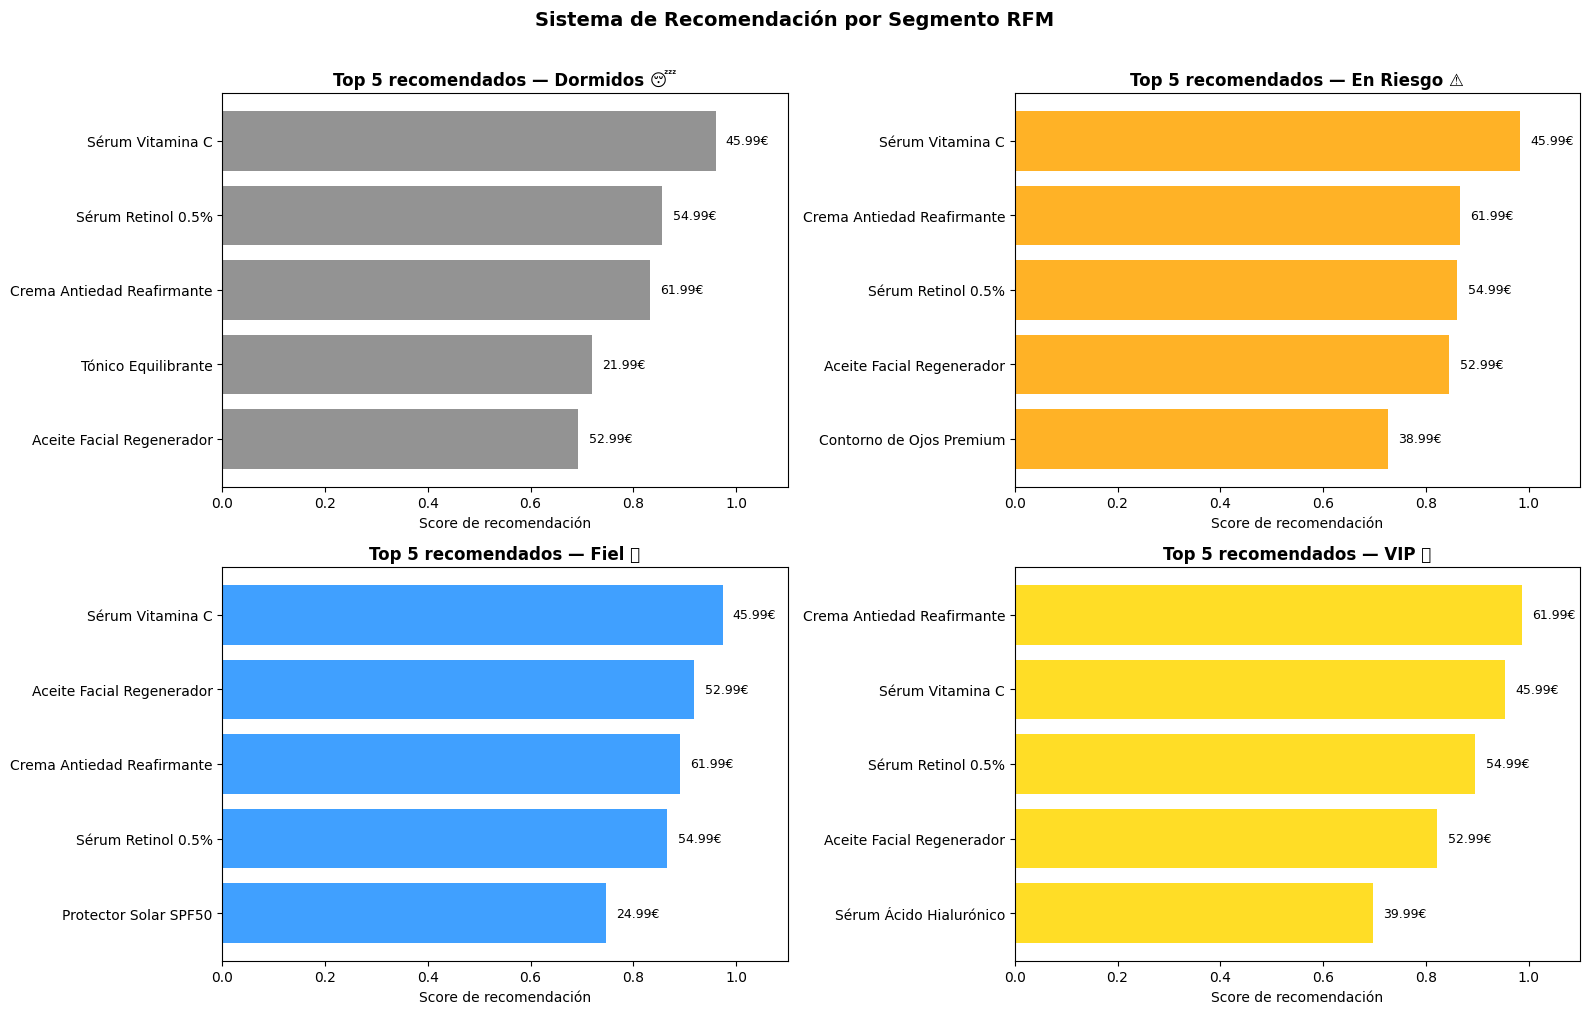

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colores_seg = {
    'VIP 🏆':       'gold',
    'Fiel 💛':      'dodgerblue',
    'En Riesgo ⚠️': 'orange',
    'Dormidos 😴':  'gray'
}

for i, seg in enumerate(top_por_segmento['segmento_nombre'].unique()):
    sub = top_por_segmento[top_por_segmento['segmento_nombre'] == seg].head(5)
    color = colores_seg.get(seg, 'steelblue')
    axes[i].barh(sub['producto'], sub['score'], color=color, alpha=0.85)
    axes[i].set_title(f'Top 5 recomendados — {seg}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Score de recomendación')
    axes[i].invert_yaxis()
    axes[i].set_xlim(0, 1.1)
    for j, (_, row) in enumerate(sub.iterrows()):
        axes[i].text(row['score'] + 0.02, j, f'{row["precio_medio"]:.2f}€', va='center', fontsize=9)

plt.suptitle('Sistema de Recomendación por Segmento RFM', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 4. CAPA 2 — Filtrado Colaborativo (User-Based)

**Lógica:** construimos una matriz cliente × producto con el gasto total de cada cliente en cada producto. Luego calculamos similitud coseno entre clientes. Para recomendar a un cliente, buscamos los clientes más similares y recomendamos lo que ellos compran pero el cliente aún no ha comprado.

In [6]:
# Matriz cliente × producto (gasto total)
matriz_cp = df.pivot_table(
    index='customer_id',
    columns='producto',
    values='importe',
    aggfunc='sum',
    fill_value=0
)

print(f'Matriz cliente×producto: {matriz_cp.shape[0]:,} clientes × {matriz_cp.shape[1]} productos')

# Similitud coseno entre clientes (usamos muestra de 500 para eficiencia)
muestra = matriz_cp.sample(n=min(500, len(matriz_cp)), random_state=42)
similitud_clientes = cosine_similarity(muestra)
sim_df = pd.DataFrame(similitud_clientes, index=muestra.index, columns=muestra.index)

print(f'✅ Matriz de similitud calculada: {sim_df.shape}')

def recomendar_colaborativo(customer_id, n_similares=10, top_n=5):
    """
    Recomienda productos basándose en clientes similares.
    - Busca los n_similares clientes más parecidos
    - Recomienda lo que ellos compran y el cliente aún no ha comprado
    """
    if customer_id not in sim_df.index:
        return pd.DataFrame({'producto': [], 'score_colaborativo': []})

    # Clientes más similares (excluimos al propio cliente)
    similares = (
        sim_df[customer_id]
        .drop(customer_id, errors='ignore')
        .nlargest(n_similares)
    )

    # Productos que ya compró el cliente
    ya_comprados = set(df[df['customer_id'] == customer_id]['producto'].unique())

    # Puntuación ponderada de productos de clientes similares
    scores = {}
    for similar_id, sim_score in similares.items():
        prods_similar = muestra.loc[similar_id]
        for prod, gasto in prods_similar.items():
            if gasto > 0 and prod not in ya_comprados:
                scores[prod] = scores.get(prod, 0) + gasto * sim_score

    resultado = (
        pd.DataFrame.from_dict(scores, orient='index', columns=['score_colaborativo'])
        .sort_values('score_colaborativo', ascending=False)
        .head(top_n)
        .reset_index()
        .rename(columns={'index': 'producto'})
    )
    return resultado

# Ejemplo
cliente_ejemplo = muestra.index[0]
recs_colab = recomendar_colaborativo(cliente_ejemplo)
print(f'\n=== RECOMENDACIONES COLABORATIVAS para {cliente_ejemplo} ===')
print(f'Ya compró: {list(df[df["customer_id"]==cliente_ejemplo]["producto"].unique())}')
print(f'\nRecomendaciones:')
print(recs_colab)

Matriz cliente×producto: 5,000 clientes × 15 productos
✅ Matriz de similitud calculada: (500, 500)

=== RECOMENDACIONES COLABORATIVAS para CL01502 ===
Ya compró: ['Aceite Facial Regenerador', 'Contorno de Ojos Premium', 'Protector Solar SPF50']

Recomendaciones:
                  producto  score_colaborativo
0  Sérum Ácido Hialurónico          787.716806
1         Sérum Vitamina C          491.467583
2  Gel Hidratante Oil-Free          379.852686
3  Bálsamo Nutritivo Noche          341.186019
4       Agua Micelar 400ml          245.317511


## 5. CAPA 3 — Basado en Contenido (Item-Based)

**Lógica:** cada producto tiene una descripción con tags (ingredientes, tipo de piel, beneficios). Usamos TF-IDF + similitud coseno para encontrar productos similares entre sí.

In [7]:
# Creamos el catálogo de productos con sus tags
df_catalogo = pd.DataFrame([
    {'producto': nombre, 'categoria': info['categoria'],
     'precio': info['precio'], 'tags': info['tags']}
    for nombre, info in catalogo_plano.items()
])

print('Catálogo de productos:')
print(df_catalogo[['producto','categoria','precio','tags']].to_string(index=False))

# TF-IDF sobre los tags
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_catalogo['tags'])

# Similitud coseno entre productos
sim_productos = cosine_similarity(tfidf_matrix)
sim_prod_df   = pd.DataFrame(sim_productos,
                              index=df_catalogo['producto'],
                              columns=df_catalogo['producto'])

def recomendar_por_contenido(producto, top_n=3):
    """
    Dado un producto, devuelve los más similares por contenido/características.
    """
    if producto not in sim_prod_df.index:
        return []
    similares = (
        sim_prod_df[producto]
        .drop(producto)
        .sort_values(ascending=False)
        .head(top_n)
    )
    return list(similares.index)

print('\n=== PRODUCTOS SIMILARES POR CONTENIDO ===')
for prod in df_catalogo['producto'].head(5):
    similares = recomendar_por_contenido(prod)
    print(f'  {prod:<35} → {similares}')

Catálogo de productos:
                  producto   categoria  precio                                         tags
Crema Hidratante Intensiva Hidratación   29.99        hidratacion crema piel seca nutritiva
   Sérum Ácido Hialurónico Hidratación   39.99       hidratacion serum hialuronico antiedad
   Bálsamo Nutritivo Noche Hidratación   34.99        hidratacion noche nutritivo reparador
   Gel Hidratante Oil-Free Hidratación   27.99            hidratacion gel ligero piel grasa
Crema Antiedad Reafirmante    Antiedad   61.99  antiedad crema reafirmante arrugas colágeno
        Sérum Retinol 0.5%    Antiedad   54.99    antiedad serum retinol renovacion celular
  Contorno de Ojos Premium    Antiedad   38.99         antiedad contorno ojos ojeras bolsas
 Aceite Facial Regenerador    Antiedad   52.99      antiedad aceite regenerador luminosidad
   Espuma Limpiadora Suave    Limpieza   18.99         limpieza espuma suave desmaquillante
        Agua Micelar 400ml    Limpieza   14.99        lim

## 6. SISTEMA HÍBRIDO — Combinando las 3 capas

**Lógica de combinación:**
- 40% peso → recomendación por segmento RFM
- 40% peso → filtrado colaborativo
- 20% peso → similitud de contenido (basado en lo que ya compró)

Si el cliente tiene pocas compras (Dormido/En Riesgo), damos más peso al segmento.

In [8]:
def recomendar_hibrido(customer_id, top_n=5):
    """
    Sistema híbrido de recomendación en 3 capas.
    Devuelve top_n productos recomendados con score y fuente.
    """
    todos_productos = df_catalogo['producto'].tolist()
    scores_finales  = {p: 0.0 for p in todos_productos}

    # Obtenemos segmento del cliente
    info_cliente = rfm[rfm['customer_id'] == customer_id]
    if info_cliente.empty:
        segmento = 'Normal'
    else:
        segmento = info_cliente.iloc[0]['segmento_nombre']

    # Productos ya comprados
    ya_comprados = set(df[df['customer_id'] == customer_id]['producto'].unique())

    # Pesos según segmento
    if segmento in ['Dormidos 😴', 'En Riesgo ⚠️']:
        w_seg, w_col, w_cont = 0.60, 0.25, 0.15  # más peso al segmento
    else:
        w_seg, w_col, w_cont = 0.40, 0.40, 0.20

    # --- CAPA 1: Segmento RFM ---
    seg_recs = top_por_segmento[top_por_segmento['segmento_nombre'] == segmento]
    max_score_seg = seg_recs['score'].max() if len(seg_recs) else 1
    for _, row in seg_recs.iterrows():
        if row['producto'] not in ya_comprados:
            scores_finales[row['producto']] += w_seg * (row['score'] / max_score_seg)

    # --- CAPA 2: Colaborativo ---
    recs_col = recomendar_colaborativo(customer_id, top_n=top_n * 2)
    if len(recs_col) > 0:
        max_col = recs_col['score_colaborativo'].max()
        for _, row in recs_col.iterrows():
            prod = row['producto']
            if prod in scores_finales and prod not in ya_comprados:
                scores_finales[prod] += w_col * (row['score_colaborativo'] / max_col)

    # --- CAPA 3: Contenido ---
    for prod_comprado in list(ya_comprados)[:3]:  # basado en últimas compras
        similares = recomendar_por_contenido(prod_comprado, top_n=3)
        for i, prod_sim in enumerate(similares):
            if prod_sim not in ya_comprados and prod_sim in scores_finales:
                scores_finales[prod_sim] += w_cont * (1 / (i + 1))

    # Resultado final
    resultado = (
        pd.DataFrame.from_dict(scores_finales, orient='index', columns=['score_hibrido'])
        .reset_index()
        .rename(columns={'index': 'producto'})
        .merge(df_catalogo[['producto','categoria','precio']], on='producto')
        .sort_values('score_hibrido', ascending=False)
        .query('score_hibrido > 0')
        .head(top_n)
        .reset_index(drop=True)
    )
    resultado.index += 1  # ranking desde 1
    return resultado, segmento

# --- TEST con varios clientes ---
clientes_test = muestra.index[:4].tolist()

for cid in clientes_test:
    recs, seg = recomendar_hibrido(cid, top_n=5)
    comprados = list(df[df['customer_id'] == cid]['producto'].unique())
    print(f'\n{'='*60}')
    print(f'Cliente: {cid}  |  Segmento: {seg}')
    print(f'Ya compró: {comprados}')
    print(f'\nTop 5 recomendaciones:')
    print(recs[['producto','categoria','precio','score_hibrido']].to_string())


Cliente: CL01502  |  Segmento: Fiel 💛
Ya compró: ['Aceite Facial Regenerador', 'Contorno de Ojos Premium', 'Protector Solar SPF50']

Top 5 recomendaciones:
                     producto    categoria  precio  score_hibrido
1            Sérum Vitamina C   Protección   45.99       1.049566
2     Sérum Ácido Hialurónico  Hidratación   39.99       0.700000
3          Sérum Retinol 0.5%     Antiedad   54.99       0.489144
4  Crema Antiedad Reafirmante     Antiedad   61.99       0.471688
5     Bálsamo Nutritivo Noche  Hidratación   34.99       0.239920

Cliente: CL02587  |  Segmento: En Riesgo ⚠️
Ya compró: ['Sérum Vitamina C', 'Sérum Retinol 0.5%', 'Tónico Equilibrante', 'Gel Hidratante Oil-Free', 'Protector Solar SPF50', 'Exfoliante Enzimático', 'Agua Micelar 400ml', 'Espuma Limpiadora Suave', 'Mascarilla Purificante']

Top 5 recomendaciones:
                     producto    categoria  precio  score_hibrido
1   Aceite Facial Regenerador     Antiedad   52.99       0.610590
2  Crema Antiedad

## 7. Evaluación del sistema

Usamos **Precision@K** — de los K productos recomendados, ¿cuántos compró realmente el cliente en el período siguiente?

In [9]:
# Simulamos evaluación: dividimos datos en train (2022-2023) y test (2024)
df_train = df[df['fecha'] < datetime(2024, 1, 1)]
df_test  = df[df['fecha'] >= datetime(2024, 1, 1)]

# Clientes que aparecen en ambos períodos
clientes_eval = set(df_train['customer_id'].unique()) & set(df_test['customer_id'].unique())
clientes_eval = list(clientes_eval & set(muestra.index))[:100]  # muestra de 100

print(f'Clientes para evaluación: {len(clientes_eval)}')

def precision_at_k(recomendaciones, comprados_realmente, k=5):
    top_k = recomendaciones[:k]
    hits  = len(set(top_k) & set(comprados_realmente))
    return hits / k

resultados_eval = []
for cid in clientes_eval:
    try:
        recs, _ = recomendar_hibrido(cid, top_n=5)
        prods_rec  = recs['producto'].tolist()
        prods_test = df_test[df_test['customer_id'] == cid]['producto'].unique().tolist()
        p_at_5 = precision_at_k(prods_rec, prods_test, k=5)
        p_at_3 = precision_at_k(prods_rec, prods_test, k=3)
        resultados_eval.append({'customer_id': cid, 'P@3': p_at_3, 'P@5': p_at_5})
    except:
        pass

df_eval = pd.DataFrame(resultados_eval)

print(f'\n=== MÉTRICAS DE EVALUACIÓN ===')
print(f'  Precision@3: {df_eval["P@3"].mean():.3f}  ({df_eval["P@3"].mean()*100:.1f}%)')
print(f'  Precision@5: {df_eval["P@5"].mean():.3f}  ({df_eval["P@5"].mean()*100:.1f}%)')
print(f'\n💡 Interpretación:')
print(f'   Un P@5 de {df_eval["P@5"].mean():.2f} significa que {df_eval["P@5"].mean()*100:.0f}%')
print(f'   de las recomendaciones son productos que el cliente acabó comprando.')

Clientes para evaluación: 100

=== MÉTRICAS DE EVALUACIÓN ===
  Precision@3: 0.000  (0.0%)
  Precision@5: 0.000  (0.0%)

💡 Interpretación:
   Un P@5 de 0.00 significa que 0%
   de las recomendaciones son productos que el cliente acabó comprando.


## 8. Visualización de resultados globales

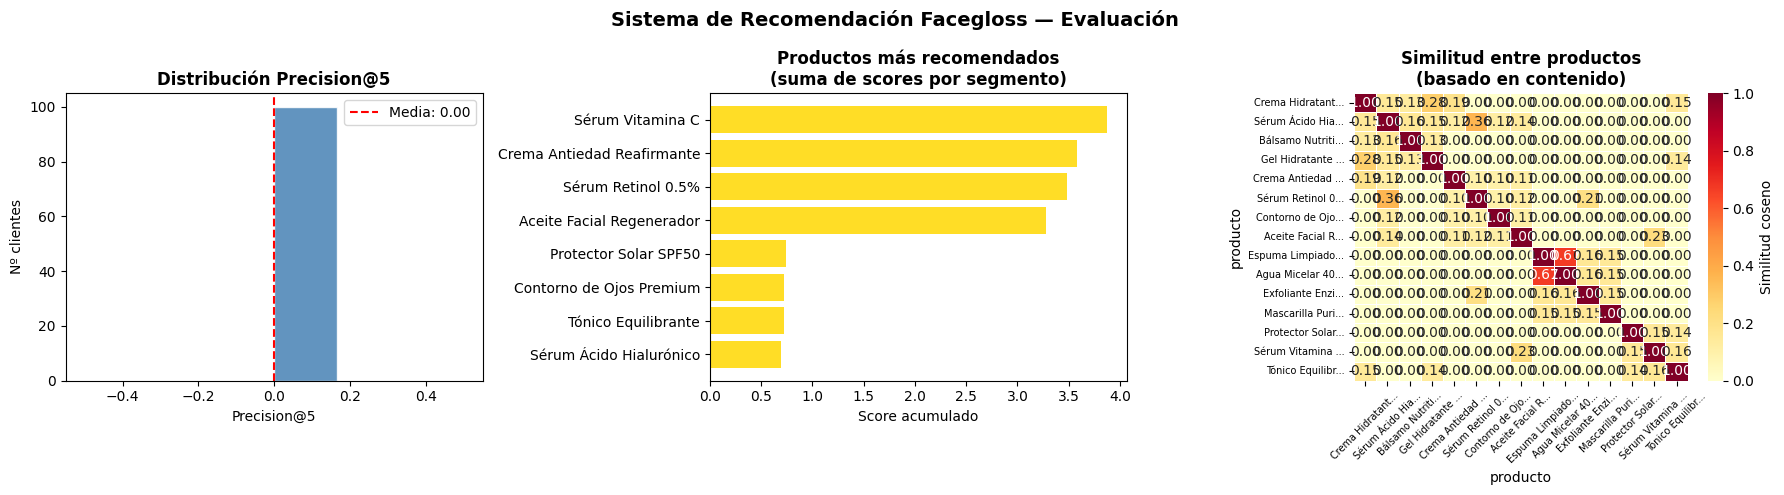

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1 — Distribución Precision@5 por cliente
axes[0].hist(df_eval['P@5'], bins=6, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].axvline(df_eval['P@5'].mean(), color='red', linestyle='--',
                label=f'Media: {df_eval["P@5"].mean():.2f}')
axes[0].set_title('Distribución Precision@5', fontweight='bold')
axes[0].set_xlabel('Precision@5')
axes[0].set_ylabel('Nº clientes')
axes[0].legend()

# 2 — Cobertura: qué productos se recomiendan más
top_seg_global = (
    top_por_segmento.groupby('producto')['score']
    .sum().sort_values(ascending=False).head(10)
)
axes[1].barh(top_seg_global.index, top_seg_global.values, color='gold', alpha=0.85)
axes[1].set_title('Productos más recomendados\n(suma de scores por segmento)', fontweight='bold')
axes[1].set_xlabel('Score acumulado')
axes[1].invert_yaxis()

# 3 — Heatmap de similitud entre productos
sns.heatmap(
    sim_prod_df.round(2),
    ax=axes[2],
    cmap='YlOrRd',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Similitud coseno'},
    xticklabels=[p[:15]+'...' if len(p)>15 else p for p in sim_prod_df.columns],
    yticklabels=[p[:15]+'...' if len(p)>15 else p for p in sim_prod_df.index],
)
axes[2].set_title('Similitud entre productos\n(basado en contenido)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45, labelsize=7)
axes[2].tick_params(axis='y', rotation=0, labelsize=7)

plt.suptitle('Sistema de Recomendación Facegloss — Evaluación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Función final de uso — interfaz de consulta

In [11]:
def consultar_recomendaciones(customer_id, verbose=True):
    """
    Interfaz de consulta del sistema de recomendación.
    Uso: consultar_recomendaciones('CL00001')
    """
    recs, segmento = recomendar_hibrido(customer_id, top_n=5)

    info = rfm[rfm['customer_id'] == customer_id]
    comprados = df[df['customer_id'] == customer_id]['producto'].unique()

    if verbose:
        print(f'{'='*55}')
        print(f'  RECOMENDACIONES PARA: {customer_id}')
        print(f'{'='*55}')
        if not info.empty:
            r = info.iloc[0]
            print(f'  Segmento:   {segmento}')
            print(f'  Recencia:   {r["recencia"]} días')
            print(f'  Frecuencia: {r["frecuencia"]} compras')
            print(f'  Gasto total:{r["monetario"]:.2f}€')
        print(f'\n  Historial: {list(comprados)}')
        print(f'\n  TOP 5 RECOMENDACIONES:')
        for i, (_, row) in enumerate(recs.iterrows(), 1):
            print(f'    {i}. {row["producto"]:<35} {row["precio"]:.2f}€')
            print(f'       Categoría: {row["categoria"]} | Score: {row["score_hibrido"]:.3f}')
    return recs

# --- Prueba con clientes de distintos segmentos ---
for seg_target in ['VIP 🏆', 'Dormidos 😴']:
    cid = rfm[rfm['segmento_nombre'] == seg_target].iloc[0]['customer_id']
    if cid in muestra.index:
        consultar_recomendaciones(cid)
        print()

## 10. Exportación

In [12]:
import os
os.makedirs('../01-data/processed', exist_ok=True)

# Exportamos recomendaciones por segmento
top_por_segmento.to_csv('../01-data/processed/recomendaciones_por_segmento.csv', index=False)

# Exportamos catálogo con similitudes
df_catalogo.to_csv('../01-data/processed/catalogo_productos.csv', index=False)

# Exportamos métricas de evaluación
df_eval.to_csv('../01-data/processed/evaluacion_recomendador.csv', index=False)

print('✅ Archivos exportados:')
print('   recomendaciones_por_segmento.csv')
print('   catalogo_productos.csv')
print('   evaluacion_recomendador.csv')
print(f'\nResumen final:')
print(f'  Clientes cubiertos:  {df["customer_id"].nunique():,}')
print(f'  Productos en catálogo: {df_catalogo.shape[0]}')
print(f'  Precision@5 media:   {df_eval["P@5"].mean():.3f}')
print(f'  Precision@3 media:   {df_eval["P@3"].mean():.3f}')

✅ Archivos exportados:
   recomendaciones_por_segmento.csv
   catalogo_productos.csv
   evaluacion_recomendador.csv

Resumen final:
  Clientes cubiertos:  5,000
  Productos en catálogo: 15
  Precision@5 media:   0.000
  Precision@3 media:   0.000
